<a href="https://colab.research.google.com/github/redwineyards/autoencoders/blob/main/simple-autoencoders/conv_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
seed=42
torch.manual_seed(seed)
if device=='cuda': torch.cuda.manual_seed_all(seed)

root="/content/data"
trans=transforms.Compose([transforms.ToTensor()])
training_set=torchvision.datasets.MNIST(root=root,train=True,transform=trans,download=True)
test_set=torchvision.datasets.MNIST(root=root, train=False,transform=trans, download=True)

num_epochs=15
learning_rate=1e-3
batch_size=128
train_loader=torch.utils.data.DataLoader(training_set,batch_size=batch_size,shuffle=True)
test_loader=torch.utils.data.DataLoader(test_set,batch_size=batch_size,shuffle=False)

True
Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting /content/data/MNIST/raw/train-images-idx3-ubyte.gz to /content/data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting /content/data/MNIST/raw/train-labels-idx1-ubyte.gz to /content/data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting /content/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting /content/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [7]:
class ConvAE(nn.Module):
  def __init__(self):
    super(ConvAE,self).__init__()
    self.encoder=nn.Sequential(
        nn.Conv2d(1,8,5,stride=1),
        nn.ReLU(),
        nn.Conv2d(8,16,3,stride=2),
        nn.ReLU(),
        nn.Conv2d(16,32,1,stride=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.MaxPool2d(2, 2),
    )
    self.decoder=nn.Sequential(
        nn.ConvTranspose2d(32,32,3, stride=2),nn.ReLU(),
        nn.ConvTranspose2d(32,16,3, stride=2),
        nn.ReLU(),
        nn.ConvTranspose2d(16,8,5, stride=2),
        nn.ReLU(),
        nn.ConvTranspose2d(8,1,4, stride=1),
        nn.Sigmoid()
    )
  def encode(self,input):
    features=self.encoder(input.float())
    return features
  def decode(self,features):
    reconstruction=self.decoder(features.float())
    return reconstruction
  def forward(self,x):
    output=self.encode(x)
    output=self.decode(output)
    return output

In [8]:
def train(model,train_loader,num_epochs,learning_rate):
  losses=[]
  optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)
  lossfn=torch.nn.BCELoss()
  model.train()
  for epoch in range(num_epochs):
    for i,(images,_) in enumerate(train_loader):
      images=images.to(device)
      output=model.forward(images)
      loss=lossfn(output,images.float())
      losses.append(loss)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      if (i + 1) % 200 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs,loss.item()))
  return losses

In [9]:
def evaluate(model,test_loader):
  lossfn=torch.nn.BCELoss()
  model.eval()
  with torch.no_grad():
    total=0
    for i,(images,_) in enumerate(test_loader):
      images=images.to(device)
      output=model.forward(images)
      total+=lossfn(output,images.float())
    
    loss=total/len(test_loader)
    print("model test loss on MNIST test set:", loss.item())

In [10]:
model=ConvAE().to(device)
losses=train(model,train_loader,num_epochs,learning_rate)

Epoch [1/15], Loss: 0.2359
Epoch [1/15], Loss: 0.1996
Epoch [2/15], Loss: 0.1711
Epoch [2/15], Loss: 0.1673
Epoch [3/15], Loss: 0.1616
Epoch [3/15], Loss: 0.1576
Epoch [4/15], Loss: 0.1471
Epoch [4/15], Loss: 0.1415
Epoch [5/15], Loss: 0.1406
Epoch [5/15], Loss: 0.1426
Epoch [6/15], Loss: 0.1345
Epoch [6/15], Loss: 0.1307
Epoch [7/15], Loss: 0.1386
Epoch [7/15], Loss: 0.1361
Epoch [8/15], Loss: 0.1341
Epoch [8/15], Loss: 0.1340
Epoch [9/15], Loss: 0.1286
Epoch [9/15], Loss: 0.1320
Epoch [10/15], Loss: 0.1305
Epoch [10/15], Loss: 0.1196
Epoch [11/15], Loss: 0.1233
Epoch [11/15], Loss: 0.1272
Epoch [12/15], Loss: 0.1254
Epoch [12/15], Loss: 0.1250
Epoch [13/15], Loss: 0.1301
Epoch [13/15], Loss: 0.1208
Epoch [14/15], Loss: 0.1249
Epoch [14/15], Loss: 0.1234
Epoch [15/15], Loss: 0.1275
Epoch [15/15], Loss: 0.1263


In [11]:
evaluate(model,test_loader)

model test loss on MNIST test set: 0.1189308911561966


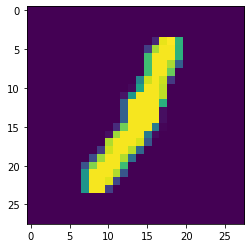

In [26]:
tens1=training_set[113][0].reshape(-1,1,28,28)
#tens1=torch.rand(1,1,28,28)*0.1
test1=np.squeeze(tens1.numpy())
plt.imshow(test1)

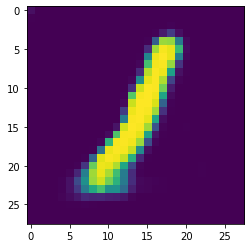

In [27]:
with torch.no_grad():
  tens1_reconstr=model.forward(tens1.to(device))
  test1_reconstr=np.squeeze(tens1_reconstr.cpu().numpy())
  plt.imshow(test1_reconstr)